# Text Classification of Rap Songs

This task is an attempt to classify rap songs into groups based on lyrics

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
%matplotlib inline

plt.style.use('seaborn')

In [2]:
#load file
df = pd.read_csv(r"C:\Users\austi\OneDrive\Documents\rap_songs.csv")
df = df.convert_dtypes()

In [3]:
#Cleaning up unwanted symbols that are present in the dataset
df['writers'] = df['writers'].str.replace("'", "")
df['lyrics'] = df['lyrics'].str.replace('\n', ' ')
df['lyrics'] = df['lyrics'].str.replace('(', '')
df['lyrics'] = df['lyrics'].str.replace(')', '')
df['lyrics'] = df['lyrics'].str.lower()
df = df.dropna(subset = ['lyrics'])
df['lyrics'].sample(5)

8337     a lau on the beat yuh, oh, oh, oh haha okay li...
7350     6 in the morning, police at my door fresh adid...
15851    money - m-o-n-e-y money! money - m-o-n-e-y mon...
18279    i don't get tired  i woke up feelin' like i co...
3759     and can no hood fuck with gangsta shit  stone ...
Name: lyrics, dtype: string

In [4]:
#Find word counts
df['word_count'] = df['lyrics'].apply(lambda x: len(str(x).split(" ")))
df[['title','word_count']].head()

,title,word_count
0,Hit 'Em Up,1146
1,Changes,891
2,Keep Ya Head Up,866
3,Hail Mary,924
4,Dear Mama,705


Ranking artists by average words per song.

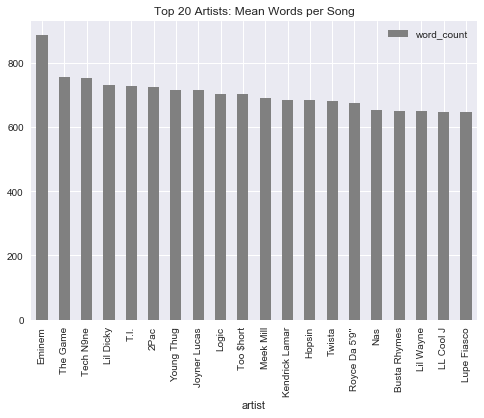

In [5]:
avg = df.groupby(['artist'])['word_count'].mean().reset_index()
avg.sort_values('word_count', ascending = False)[:20].plot(kind = 'bar', x ='artist', color='grey', title='Top 20 Artists: Mean Words per Song')

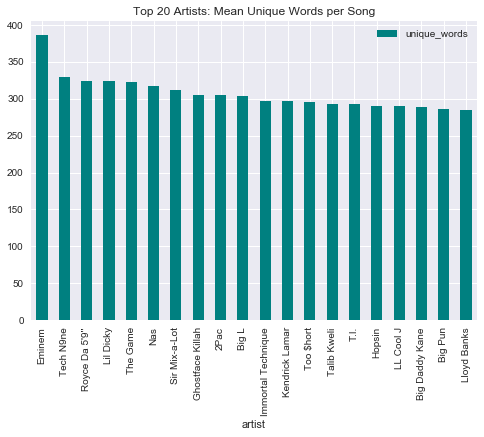

In [6]:
df['unique_words'] = df['lyrics'].apply(lambda x: len(set(str(x).split(" "))))
avg_unique = df.groupby(['artist'])['unique_words'].mean().reset_index()
avg_unique.sort_values('unique_words', ascending = False)[:20].plot(kind = 'bar', x ='artist', color='teal', title='Top 20 Artists: Mean Unique Words per Song')

# Data Preprocessing

In [11]:
# Cleaning lyrics
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop]) #removing stopwords
    punc_free = ''.join(ch for ch in stop_free if ch not in punc) #removing punctuation
    num_free = ''.join([i for i in punc_free if not i.isdigit()]) #remove numbers
    single_free = ' '.join(word for word in num_free.split() if len(word)>2) #remove 1 character words
    normalized = " ".join(lemma.lemmatize(word) for word in single_free.split()) #lemmatizing words
    return normalized

df['lyrics_clean'] = df.apply(lambda x: clean(x['lyrics']), axis = 1)     

In [12]:
df['lyrics_clean'].sample(5)

7663     hey yeah want proud sistas stand want everybod...
9391     pennyfeather heart time square new york city b...
17027    krayzie bone burn cause want smoke burn lost s...
5596     gunpowder fingertip cocaine fingernail look ma...
13015    last rickster def jam agree kinda amazing folk...
Name: lyrics_clean, dtype: object

In [13]:
freq_dists, total_words = [], []
# Tokenize the song lyrics
tokens = df.lyrics_clean.str.split(expand =True).stack()

# Calculate word frequencies
freq_dists.append(nltk.FreqDist(tokens))
    
# Calculate total number of words
all_words = []
for lyrics in df.lyrics_clean:
    all_words.extend(lyrics.split(' '))
total_words.append(len(all_words))

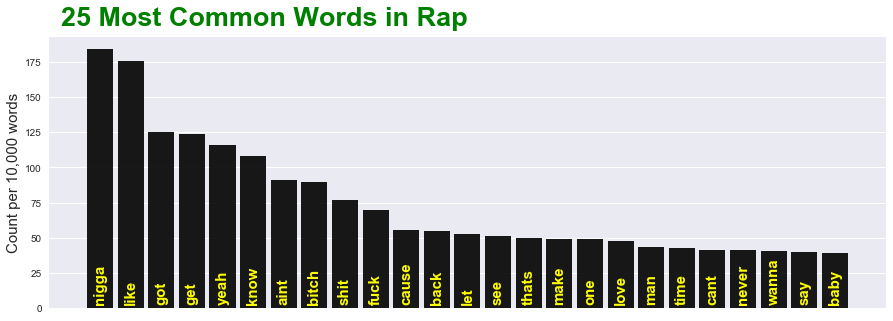

In [14]:
#Plotting most used words
num_words = 25
FS = 20
fig, axs = plt.subplots(nrows=len(freq_dists), figsize=(15, 5), sharex=True)
words, counts = zip(*[(word,count) for word, count in freq_dists[0].most_common(num_words)])
idxs = np.arange(num_words)

# Normalize to 'Usage per 10,000 words'
counts = 10000*(np.asarray(counts)/total_words)
    
# Graph skeleton
axs.bar(idxs, counts, width=0.85, color='black', alpha=0.9)
axs.set_ylabel('Count per 10,000 words', fontsize=FS-5)
axs.set_xticks([])
axs.grid(True)

# Adding song words to the plot
params = {'fontsize': FS-5, 'rotation':90, 'va':'bottom', 'ha':'center',
              'color':'yellow', 'alpha':1, 'weight':'heavy'}
for idx, word in zip(idxs, words):
    axs.text(idx, 2.6, word, fontdict=params)

y = axs.get_ylim()[1]
x = idxs[-1]*1.04    
xlim = axs.get_xlim()
mid = np.mean(xlim)
params_title = {'fontsize': FS+7, 'weight': 'heavy', 'ha': 'right', 'va':'bottom',
              'alpha': 1, 'color':'green', 'zorder':500}  
axs.set_title("25 Most Common Words in Rap", fontdict=params_title)

plt.show()

In [92]:
#Transforming words in lyrics into a TFIDF vector
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.03, ngram_range =(1,2))
X = vectorizer.fit_transform(df['lyrics_clean']).toarray()
X.shape

(19027, 1085)

# Feature Selection

In [93]:
#Scaling data for Principal Component Analysis
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
#Reducing dimensionality with Principal Component Analysis
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(19027, 1085)

Text(0, 0.5, 'cumulative explained variance')

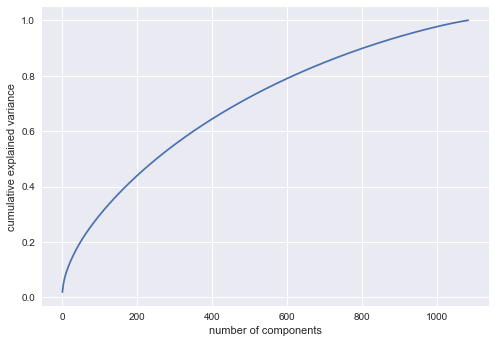

In [95]:
#Plotting variance and number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We will use 300 features, as it accounts for roughly 60% of the total variance.

In [96]:
from sklearn.decomposition import PCA
pca_2 = PCA(n_components = 400)
X_2 = pca_2.fit_transform(X_scaled)
X_2.shape

(19027, 400)

# Clustering using KMeans
Determining optimal number of clusters

In [97]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
Sum_of_squared_distances, distortions = [], []
K = range(4,18)
for k in K:
    km = KMeans(n_clusters=k, max_iter=300, n_init=1)
    km = km.fit(X_2)
    Sum_of_squared_distances.append(km.inertia_)
    distortions.append(sum(np.min(cdist(X_2, km.cluster_centers_, 'euclidean'),axis=1)) / X_2.shape[0]) 

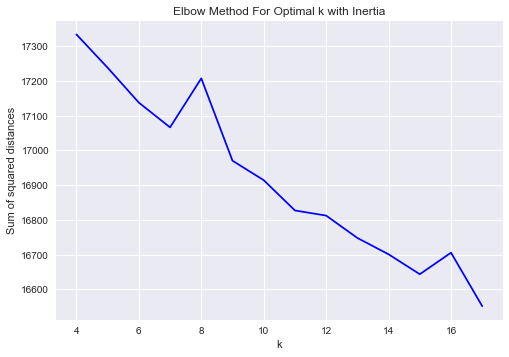

In [98]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k with Inertia')
plt.show()

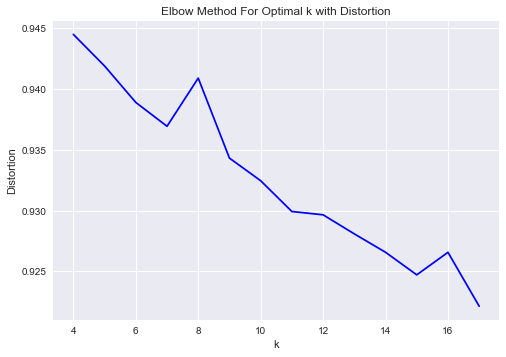

In [99]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k with Distortion')
plt.show()

As we can see in the two elbow methods, the optimal number of clusters is not very clear. There is no definite "elbow" in the charts. Additionally, distortion and inertia do not describe the quality of the clusters, such as the amount of overlap and separability. Another method to determine the optimal clusters is to calculate the average silhouette score of the clusters.

For 4 clusters, the average silhouette_score is : 0.01675737543356536

For 4 clusters, the mean of each cluster is: [0.0236252140216797, 0.07922624511107179, -0.017877646624711502, 0.03497772638587067]

For 5 clusters, the average silhouette_score is : 0.01691975220492493

For 5 clusters, the mean of each cluster is: [0.021254171113262076, 0.022995293792411078, -0.01776742807967787, 0.07731574242048656, 0.035348973728586315]

For 6 clusters, the average silhouette_score is : 0.012453557300851185

For 6 clusters, the mean of each cluster is: [-0.012825802164939613, 0.023283132604744277, 0.0791823944576897, 0.030346779681396294, -0.01798936315294889, 0.17954335544097616]

For 7 clusters, the average silhouette_score is : 0.014032476499935543

For 7 clusters, the mean of each cluster is: [0.040891003087315164, 0.02901169978123983, -0.017400542023662216, 0.04089006330757144, 0.025894058325777312, -0.019053217350689197, 0.07568834570808826]

For 8 clusters, the average silhouette_score is :

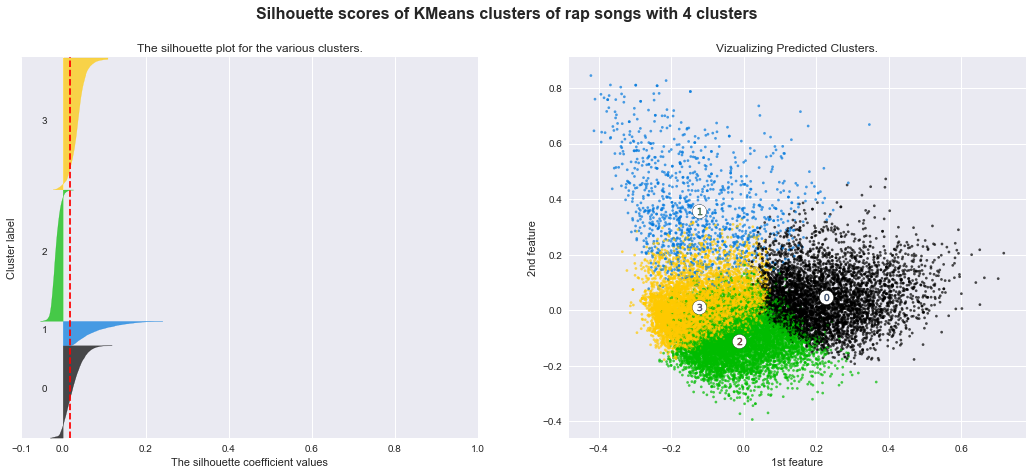

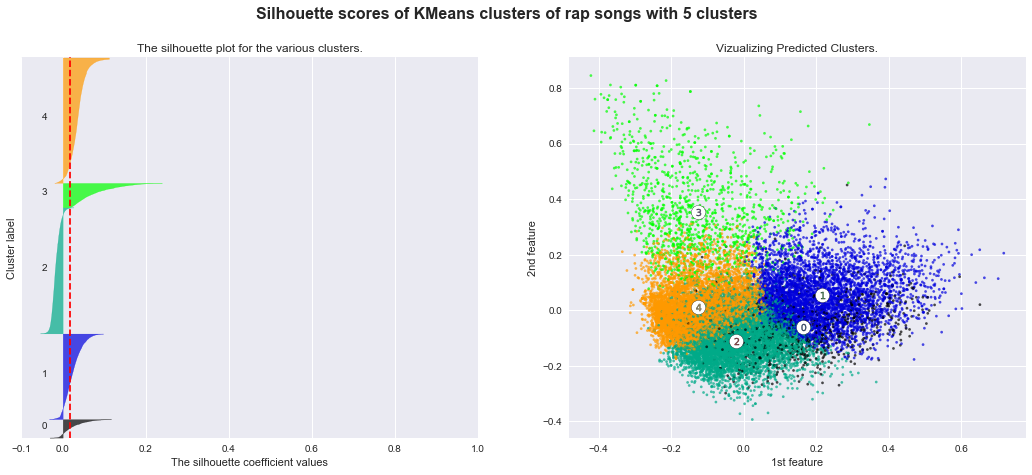

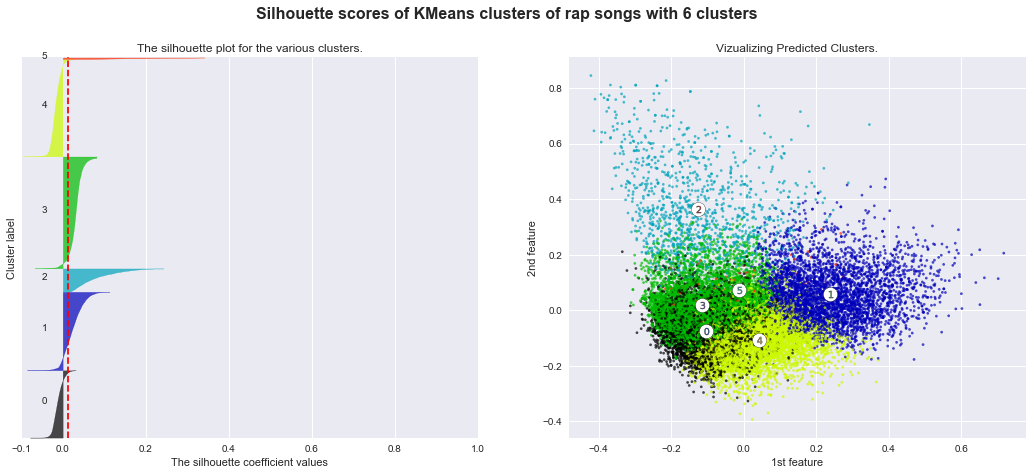

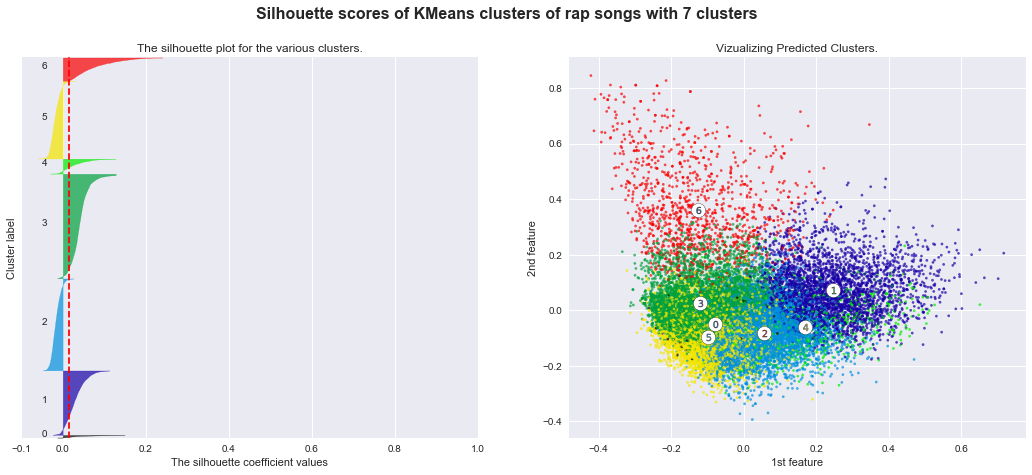

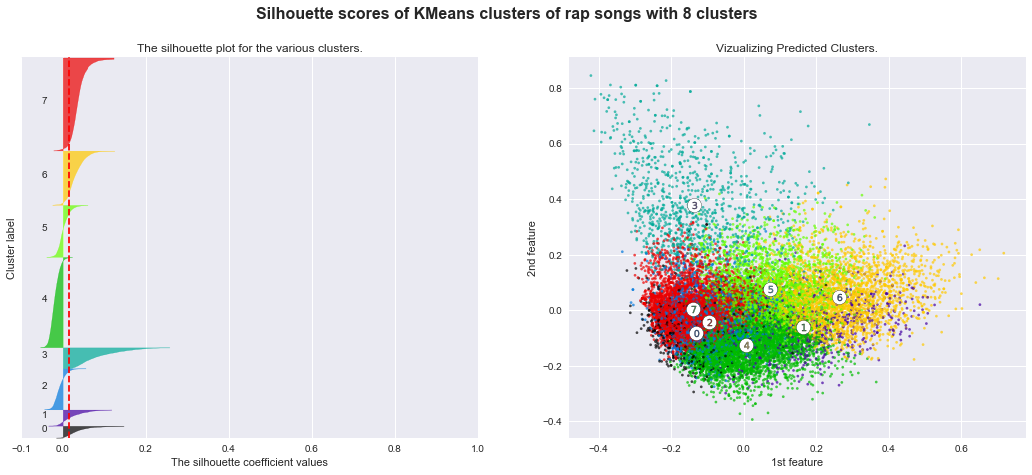

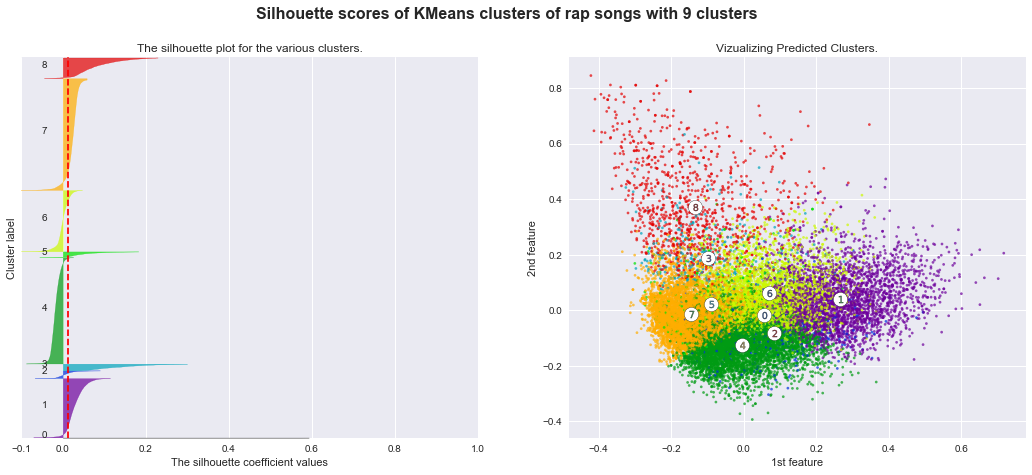

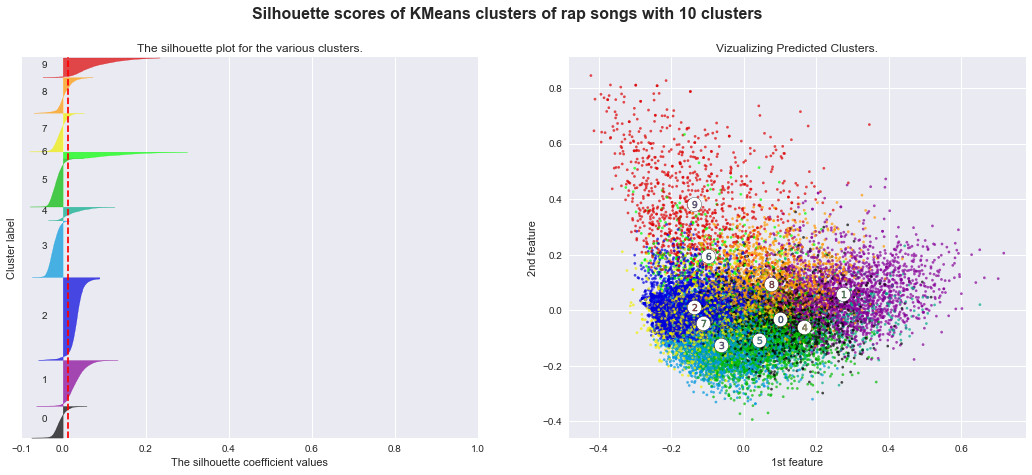

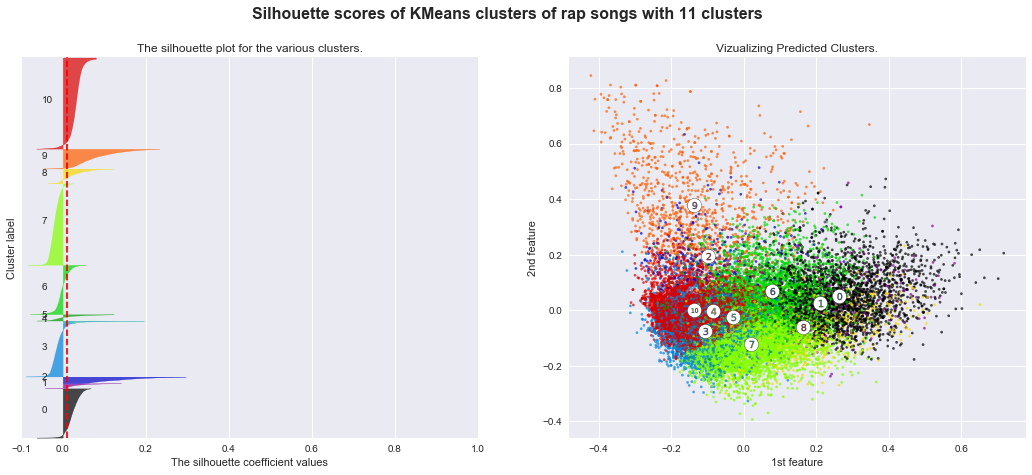

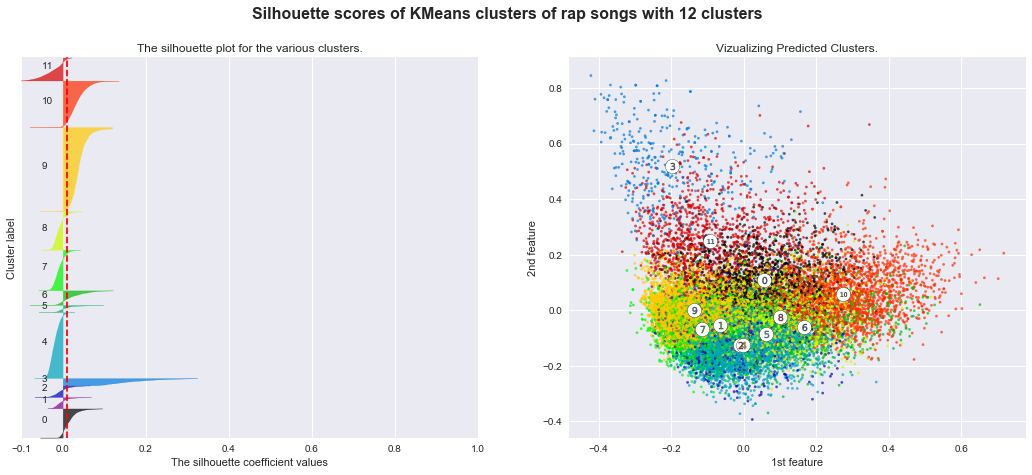

In [100]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
n_clus = range(4,13)
for clus in n_clus:
    km2 = KMeans(n_clusters=clus, max_iter=300, n_init=1).fit(X_2)
    labels= km2.predict(X_2)
    silhouette_avg = silhouette_score(X_2, labels)
    print(f"For {clus} clusters, the average silhouette_score is : {silhouette_avg}\n")
    sample_sil_values = silhouette_samples(X_2, labels)
    means_lst = []
    for label in range(clus):
        means_lst.append(sample_sil_values[labels == label].mean())
    print(f"For {clus} clusters, the mean of each cluster is: {means_lst}\n")
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # First subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_2) + (clus + 1) * 10])
    y_lower = 10
    
    for i in range(clus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        i_clus_values = \
            sample_sil_values[labels == i]

        i_clus_values.sort()

        size_cluster_i = i_clus_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clus)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, i_clus_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Second plot showing the actual clusters formed with the first two features
    colors = cm.nipy_spectral(labels.astype(float) / clus)
    ax2.scatter(X_2[:, 0], X_2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = km2.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Vizualizing Predicted Clusters.")
    ax2.set_xlabel("1st feature")
    ax2.set_ylabel("2nd feature")

    plt.suptitle(f"Silhouette scores of KMeans clusters of rap songs with {clus} clusters",
                 fontsize=16, fontweight='bold')

plt.show()

For the most part, KMeans clustering does not yield very good results with such a large amount of features. This is known as the curse of dimensionality. In our case, reducing the number of features to, let's say, 10, would allow the model to cluster the date fairly well. However, reducing features so drastically would eliminate nearly all the information in the data, which would render the model ineffective. To continue the project, we will select 5 clusters as the optimal amount as it has the greatest mean silhouette score and a somewhat less skewed distribution of clusters.

In [101]:
clus_final = 5
km_final = KMeans(n_clusters=clus_final, max_iter=300, n_init=1).fit(X_2)
labels= km_final.predict(X_2)
sample_silhouette_values = silhouette_samples(X_2, labels)
means_lst_final = []
for label in range(clus_final):
    means_lst_final.append(sample_silhouette_values[labels == label].mean())

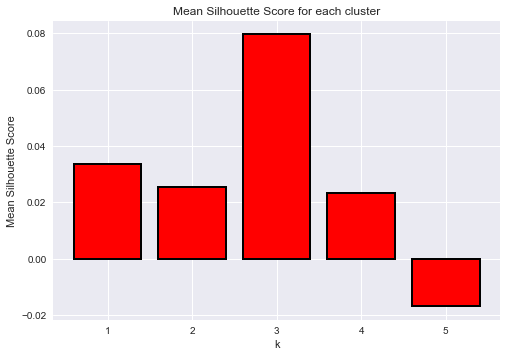

In [102]:
clus_f = range(1,clus_final+1)
bars = plt.bar(clus_f, means_lst_final, color = 'red')
for bar in bars:
    bar.set_edgecolor("black")
    bar.set_linewidth(2)
plt.xlabel('k')
plt.ylabel('Mean Silhouette Score')
plt.title('Mean Silhouette Score for each cluster')
plt.show()

Usupervised learning for text classification is a rather difficult task as words in texts are coverted into a large number of features. Most clustering algorithms do not function well with a large amount of features. This task would be much easier if there was a target feature to train a model on.

In [124]:
df['cluster'] = pd.Series(km_final.predict(X_2), index=df.index)

# Distribution of Clusters for Different Artists

Text(0.5, 1.0, 'Total Cluster Distribution')

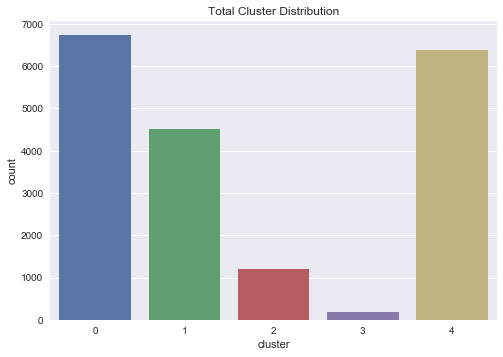

In [145]:
import seaborn as sns
sns.countplot(x='cluster', data=df).set_title('Total Cluster Distribution')

Text(0.5, 1.0, 'J. Cole Cluster Distribution')

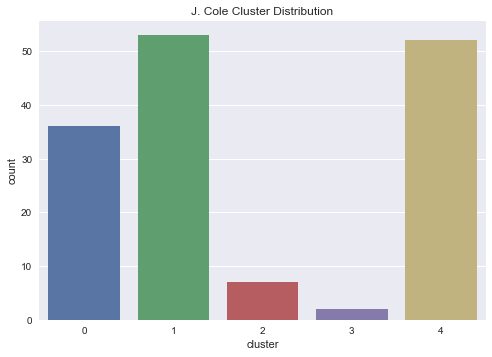

In [146]:
cole= df.loc[df['artist'] == 'J. Cole']
sns.countplot(x='cluster', data=cole).set_title('J. Cole Cluster Distribution')

Text(0.5, 1.0, 'Joey Badass cluster distribution')

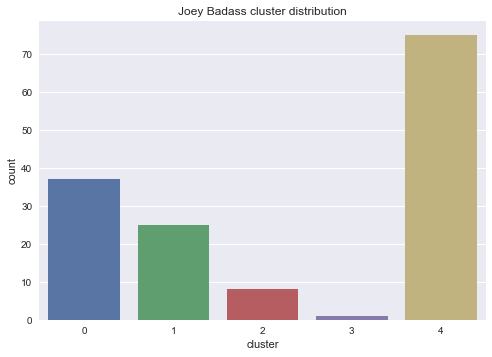

In [151]:
joey = df.loc[df['artist'] == 'Joey Bada$$']
sns.countplot(x='cluster', data =joey).set_title('Joey Badass cluster distribution')

Text(0.5, 1.0, 'DaBaby cluster distribution')

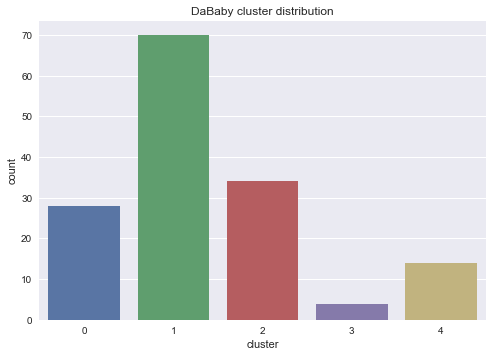

In [152]:
dababy = df.loc[df['artist'] == 'DaBaby']
sns.countplot(x='cluster', data =dababy).set_title('DaBaby cluster distribution')

Text(0.5, 1.0, 'Lil Baby cluster distribution')

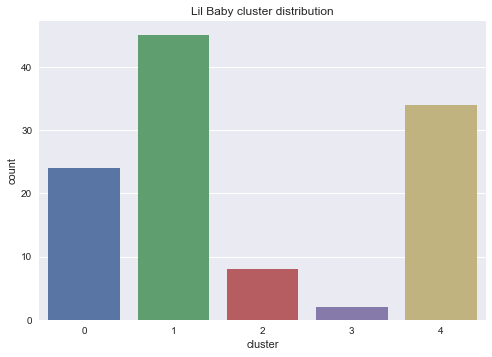

In [157]:
lil_baby = df.loc[df['artist'] == 'Lil Baby']
sns.countplot(x='cluster', data =lil_baby).set_title('Lil Baby cluster distribution')

Text(0.5, 1.0, 'Drake cluster distribution')

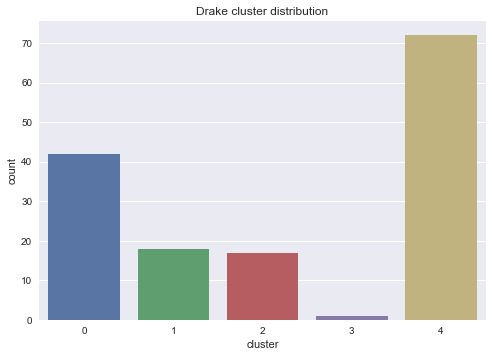

In [158]:
drake = df.loc[df['artist'] == 'Drake']
sns.countplot(x='cluster', data =drake).set_title('Drake cluster distribution')

We can see that the distribution of clusters vary from artist to artist. This can mean that each artist focuses on different topics to rap about in their songs. The following is a sample of songs from each cluster. I will leave it up to you to determine the topics of the songs in each cluster.

In [166]:
for clus in df['cluster'].unique():
    df_clus = df.loc[df['cluster'] == clus]
    print(f'Cluster No. {clus}')
    print(df_clus[['title', 'artist']].sample(5),'\n')

Cluster No. 1
                                            title        artist
6339                             Party & Bullshit    Method Man
5585                                   Situations   ScHoolboy Q
16684                            Let My 9 Get 'Em      Master P
7082   Gold Teeth And A Glock (The Creepers Song)  Denzel Curry
17822                                     We Next    Lil Yachty 

Cluster No. 2
                title     artist
18554  Down Ass Chick    Ja Rule
12730     Best Friend     DaBaby
6693     Bad Business  21 Savage
8432           Wraith       T.I.
10960   We All We Got     T-Pain 

Cluster No. 4
                                 title          artist
14478                          My City          Common
2976   Confessions of a Dangerous Mind           Logic
17466                         Mr. 17.5           Jeezy
525      Kush & Corinthians (His Pain)  Kendrick Lamar
16378                   2 Da Good Tymz  Big Daddy Kane 

Cluster No. 0
                title     